In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, entropy
import os
import numpy as np
import glob

# --- HELPER: ARCSINH TRANSFORMATION ---
def arcsinh_transform(x):
    return np.arcsinh(x)

# --- HELPER: BOOTSTRAP FOR CORRELATION ---
def compute_bootstrap_corr(x, y, n_resamples=1000):
    """
    Returns (Mean, CI_Low, CI_High) for Pearson correlation.
    """
    x_arr = np.array(x)
    y_arr = np.array(y)
    n_points = len(x_arr)
    if n_points < 5: return np.nan, np.nan, np.nan

    stats = []
    for _ in range(n_resamples):
        indices = np.random.randint(0, n_points, n_points)
        x_sub, y_sub = x_arr[indices], y_arr[indices]
        if np.std(x_sub) == 0 or np.std(y_sub) == 0: continue
        stats.append(np.corrcoef(x_sub, y_sub)[0, 1])
    
    if not stats: return np.nan, np.nan, np.nan
    return np.mean(stats), np.percentile(stats, 2.5), np.percentile(stats, 97.5)

# --- HELPER: BOOTSTRAP FOR MSE ---
def compute_bootstrap_mse(x, y, n_resamples=1000):
    x_arr = np.array(x)
    y_arr = np.array(y)
    n_points = len(x_arr)
    if n_points < 5: return np.nan, np.nan, np.nan

    stats = []
    for _ in range(n_resamples):
        indices = np.random.randint(0, n_points, n_points)
        x_sub, y_sub = x_arr[indices], y_arr[indices]
        mse_val = np.mean((x_sub - y_sub)**2)
        stats.append(mse_val)
    
    if not stats: return np.nan, np.nan, np.nan
    return np.mean(stats), np.percentile(stats, 2.5), np.percentile(stats, 97.5)

# --- MAIN SETUP ---
mos = {"Ecoli", "Bsubtilis", "Scerevisiae", "Sstipitis"}
reaction_codes = {}
reaction_codes["Ecoli"] = {"ac":["EX_ac_e"],"fru":["EX_fru_e"],"gal":["EX_gal_e"],"glcn":["EX_glcn_e"],"glc":["EX_glc__D_e"], "glyc":["EX_glyc_e"],"pyr":["EX_pyr_e"],"succ":["EX_succ_e"]}
#reaction_codes["Bsubtilis"] = {"glc":["EX_glc__D_e"],"fru":["EX_fru_e"],"glcn":["EX_glcn__D_e"], "glyc":["EX_glyc_e"],"mal":["EX_mal__L_e"],"pyr":["EX_pyr_e"], "mal_glc":["EX_mal__L_e","EX_glc__D_e"], "succ_glu":["EX_succ_e","EX_glu__L_e"]}
reaction_codes["Bsubtilis"] = {"glc":["EX_glc__D_e"],"mal":["EX_mal__L_e"],"pyr":["EX_pyr_e"], "mal_glc":["EX_mal__L_e","EX_glc__D_e"], "succ_glu":["EX_succ_e","EX_glu__L_e"]}
reaction_codes["Scerevisiae"] = {"glc":["EX_glc__D_e"],"glc_chem":["EX_glc__D_e"]}
#reaction_codes["Sstipitis"] = {"glc":["SS1232"],"glc_chem":["SS1232"]}
reaction_codes["Sstipitis"] = {"glc_chem":["SS1232"]}

df = pd.DataFrame()
sources, conditions = [], []

# Storage Lists (Initialized)
keys = ['pearson', 'ci_low', 'ci_high', 'mse', 'mse_low', 'mse_high', 
        'entropy', 'arc_r', 'arc_low', 'arc_high', 'arc_mse', 'arc_mse_low', 'arc_mse_high']

phe_res = {k: [] for k in keys}
tera_res = {k: [] for k in keys}
teraAR_res = {k: [] for k in keys} # New dictionary for TerafluxAR

path = "/home/marcelo/jupyter/teraflux/fig5"

for mo in mos:
    # Adjusted paths to use the variable 'path'
    folder1 = f"{path}/{mo}/experimental"
    folder2 = f"{path}/{mo}/results/pheflux"
    folder3 = f"{path}/{mo}/results/teraflux"
    folder4 = f"{path}/{mo}/results/teraflux_allReversible" # Folder for TerafluxAR
    
    for condition in list(reaction_codes[mo].keys()):
        # Load Data
        try:
            exp = pd.read_csv(f"{folder1}/{mo}_Fluxfile_{condition}.csv", sep="\t", lineterminator="\n").set_index("Reaction_ID")
            pheflux = pd.read_csv(glob.glob(f"{folder2}/{mo}_{condition}*.fluxes.csv")[0], sep="\t", lineterminator="\n", names=['Reaction_ID', "Flux"]).set_index("Reaction_ID") 
            teraflux = pd.read_csv(f"{folder3}/{mo}_{condition}.fluxes.csv", sep=",", lineterminator="\n", names=['Reaction_ID', "Flux"]).set_index("Reaction_ID") 
            # Load TerafluxAR data
            terafluxAR = pd.read_csv(f"{folder4}/{mo}_{condition}.fluxes.csv", sep=",", lineterminator="\n", names=['Reaction_ID', "Flux"]).set_index("Reaction_ID")
        except (IndexError, FileNotFoundError):
            print(f"Skipping {mo} {condition}")
            continue

        # Entropies
        phe_ent = entropy(abs(pheflux.Flux.values), base=2)
        tera_ent = entropy(abs(teraflux.Flux.values), base=2)
        teraAR_ent = entropy(abs(terafluxAR.Flux.values), base=2) # Entropy for TerafluxAR

        fluxes = pd.DataFrame(columns=["Experimental", "Pheflux_Simulated", "Teraflux_Simulated", "TerafluxAR_Simulated"])
        
        # Avoid division by zero if pheflux flux is 0 (though unlikely for uptake)
        denom = pheflux.loc["R_"+reaction_codes[mo][condition][0]].Flux
        if denom == 0: denom = 1e-9
        alpha = exp.loc[reaction_codes[mo][condition][0]].Flux / denom
        
        for reaction in exp.index:
            if ("Growth_rate" in reaction) or (reaction in reaction_codes[mo][condition]): continue
            # Safe retrieval
            try:
                phe_val = pheflux.loc["R_" + reaction].Flux * alpha
                tera_val = teraflux.loc["R_" + reaction].Flux
                teraAR_val = terafluxAR.loc["R_" + reaction].Flux # Get TerafluxAR value
                fluxes.loc[reaction] = [exp.loc[reaction].Flux, phe_val, tera_val, teraAR_val]
            except KeyError:
                continue

        sources.append(mo); conditions.append(condition)

        # --- PHEFLUX METRICS ---
        # 1. Standard Metrics
        p_r, _ = pearsonr(fluxes["Experimental"], fluxes["Pheflux_Simulated"])
        _, p_low, p_high = compute_bootstrap_corr(fluxes["Experimental"], fluxes["Pheflux_Simulated"])
        p_mse, p_mse_low, p_mse_high = compute_bootstrap_mse(fluxes["Experimental"], fluxes["Pheflux_Simulated"])
        
        # 2. Arcsinh Metrics 
        phe_exp_trans = arcsinh_transform(fluxes["Experimental"].astype(float))
        phe_sim_trans = arcsinh_transform(fluxes["Pheflux_Simulated"].astype(float))
        
        p_arc_r, _ = pearsonr(phe_exp_trans, phe_sim_trans)
        _, p_arc_low, p_arc_high = compute_bootstrap_corr(phe_exp_trans, phe_sim_trans)
        p_arc_mse, p_arc_mse_low, p_arc_mse_high = compute_bootstrap_mse(phe_exp_trans, phe_sim_trans)

        # Store Pheflux
        phe_res['pearson'].append(p_r); phe_res['ci_low'].append(p_low); phe_res['ci_high'].append(p_high)
        phe_res['mse'].append(p_mse); phe_res['mse_low'].append(p_mse_low); phe_res['mse_high'].append(p_mse_high)
        phe_res['entropy'].append(phe_ent)
        phe_res['arc_r'].append(p_arc_r); phe_res['arc_low'].append(p_arc_low); phe_res['arc_high'].append(p_arc_high)
        phe_res['arc_mse'].append(p_arc_mse); phe_res['arc_mse_low'].append(p_arc_mse_low); phe_res['arc_mse_high'].append(p_arc_mse_high)

        # --- TERAFLUX METRICS ---
        # 1. Standard Metrics
        t_r, _ = pearsonr(fluxes["Experimental"], fluxes["Teraflux_Simulated"])
        _, t_low, t_high = compute_bootstrap_corr(fluxes["Experimental"], fluxes["Teraflux_Simulated"])
        t_mse, t_mse_low, t_mse_high = compute_bootstrap_mse(fluxes["Experimental"], fluxes["Teraflux_Simulated"])
        
        # 2. Arcsinh Metrics 
        tera_exp_trans = arcsinh_transform(fluxes["Experimental"].astype(float))
        tera_sim_trans = arcsinh_transform(fluxes["Teraflux_Simulated"].astype(float))
        
        t_arc_r, _ = pearsonr(tera_exp_trans, tera_sim_trans)
        _, t_arc_low, t_arc_high = compute_bootstrap_corr(tera_exp_trans, tera_sim_trans)
        t_arc_mse, t_arc_mse_low, t_arc_mse_high = compute_bootstrap_mse(tera_exp_trans, tera_sim_trans)

        # Store Teraflux
        tera_res['pearson'].append(t_r); tera_res['ci_low'].append(t_low); tera_res['ci_high'].append(t_high)
        tera_res['mse'].append(t_mse); tera_res['mse_low'].append(t_mse_low); tera_res['mse_high'].append(t_mse_high)
        tera_res['entropy'].append(tera_ent)
        tera_res['arc_r'].append(t_arc_r); tera_res['arc_low'].append(t_arc_low); tera_res['arc_high'].append(t_arc_high)
        tera_res['arc_mse'].append(t_arc_mse); tera_res['arc_mse_low'].append(t_arc_mse_low); tera_res['arc_mse_high'].append(t_arc_mse_high)

        # --- TERAFLUX AR METRICS ---
        # 1. Standard Metrics
        tar_r, _ = pearsonr(fluxes["Experimental"], fluxes["TerafluxAR_Simulated"])
        _, tar_low, tar_high = compute_bootstrap_corr(fluxes["Experimental"], fluxes["TerafluxAR_Simulated"])
        tar_mse, tar_mse_low, tar_mse_high = compute_bootstrap_mse(fluxes["Experimental"], fluxes["TerafluxAR_Simulated"])
        
        # 2. Arcsinh Metrics 
        teraar_exp_trans = arcsinh_transform(fluxes["Experimental"].astype(float))
        teraar_sim_trans = arcsinh_transform(fluxes["TerafluxAR_Simulated"].astype(float))
        
        tar_arc_r, _ = pearsonr(teraar_exp_trans, teraar_sim_trans)
        _, tar_arc_low, tar_arc_high = compute_bootstrap_corr(teraar_exp_trans, teraar_sim_trans)
        tar_arc_mse, tar_arc_mse_low, tar_arc_mse_high = compute_bootstrap_mse(teraar_exp_trans, teraar_sim_trans)

        # Store TerafluxAR
        teraAR_res['pearson'].append(tar_r); teraAR_res['ci_low'].append(tar_low); teraAR_res['ci_high'].append(tar_high)
        teraAR_res['mse'].append(tar_mse); teraAR_res['mse_low'].append(tar_mse_low); teraAR_res['mse_high'].append(tar_mse_high)
        teraAR_res['entropy'].append(teraAR_ent)
        teraAR_res['arc_r'].append(tar_arc_r); teraAR_res['arc_low'].append(tar_arc_low); teraAR_res['arc_high'].append(tar_arc_high)
        teraAR_res['arc_mse'].append(tar_arc_mse); teraAR_res['arc_mse_low'].append(tar_arc_mse_low); teraAR_res['arc_mse_high'].append(tar_arc_mse_high)


# Build DataFrame
df["Data_source"] = sources
df["Condition"] = conditions

# Pheflux Columns
df["Pheflux_Pearson"] = phe_res['pearson']
df["Pheflux_Pearson_Low"] = phe_res['ci_low']
df["Pheflux_Pearson_High"] = phe_res['ci_high']
df["Pheflux_MSE"] = phe_res['mse']
df["Pheflux_MSE_Low"] = phe_res['mse_low']
df["Pheflux_MSE_High"] = phe_res['mse_high']
df["Pheflux_Entropy"] = phe_res['entropy']
df["Pheflux_Arcsinh_Pearson"] = phe_res['arc_r']
df["Pheflux_Arcsinh_Low"] = phe_res['arc_low']
df["Pheflux_Arcsinh_High"] = phe_res['arc_high']
df["Pheflux_Arcsinh_MSE"] = phe_res['arc_mse']           
df["Pheflux_Arcsinh_MSE_Low"] = phe_res['arc_mse_low']   
df["Pheflux_Arcsinh_MSE_High"] = phe_res['arc_mse_high'] 

# Teraflux Columns
df["Teraflux_Pearson"] = tera_res['pearson']
df["Teraflux_Pearson_Low"] = tera_res['ci_low']
df["Teraflux_Pearson_High"] = tera_res['ci_high']
df["Teraflux_MSE"] = tera_res['mse']
df["Teraflux_MSE_Low"] = tera_res['mse_low']
df["Teraflux_MSE_High"] = tera_res['mse_high']
df["Teraflux_Entropy"] = tera_res['entropy']
df["Teraflux_Arcsinh_Pearson"] = tera_res['arc_r']
df["Teraflux_Arcsinh_Low"] = tera_res['arc_low']
df["Teraflux_Arcsinh_High"] = tera_res['arc_high']
df["Teraflux_Arcsinh_MSE"] = tera_res['arc_mse']           
df["Teraflux_Arcsinh_MSE_Low"] = tera_res['arc_mse_low']   
df["Teraflux_Arcsinh_MSE_High"] = tera_res['arc_mse_high'] 

# TerafluxAR Columns (New)
df["TerafluxAR_Pearson"] = teraAR_res['pearson']
df["TerafluxAR_Pearson_Low"] = teraAR_res['ci_low']
df["TerafluxAR_Pearson_High"] = teraAR_res['ci_high']
df["TerafluxAR_MSE"] = teraAR_res['mse']
df["TerafluxAR_MSE_Low"] = teraAR_res['mse_low']
df["TerafluxAR_MSE_High"] = teraAR_res['mse_high']
df["TerafluxAR_Entropy"] = teraAR_res['entropy']
df["TerafluxAR_Arcsinh_Pearson"] = teraAR_res['arc_r']
df["TerafluxAR_Arcsinh_Low"] = teraAR_res['arc_low']
df["TerafluxAR_Arcsinh_High"] = teraAR_res['arc_high']
df["TerafluxAR_Arcsinh_MSE"] = teraAR_res['arc_mse']           
df["TerafluxAR_Arcsinh_MSE_Low"] = teraAR_res['arc_mse_low']   
df["TerafluxAR_Arcsinh_MSE_High"] = teraAR_res['arc_mse_high'] 

# Save or display
df.head()
# df.to_csv("comparison_metrics_with_arcsinh_mse_and_terafluxAR.csv", index=False)

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


,Data_source,Condition,Pheflux_Pearson,Pheflux_Pearson_Low,Pheflux_Pearson_High,Pheflux_MSE,Pheflux_MSE_Low,Pheflux_MSE_High,Pheflux_Entropy,Pheflux_Arcsinh_Pearson,...,TerafluxAR_MSE,TerafluxAR_MSE_Low,TerafluxAR_MSE_High,TerafluxAR_Entropy,TerafluxAR_Arcsinh_Pearson,TerafluxAR_Arcsinh_Low,TerafluxAR_Arcsinh_High,TerafluxAR_Arcsinh_MSE,TerafluxAR_Arcsinh_MSE_Low,TerafluxAR_Arcsinh_MSE_High
0,Sstipitis,glc_chem,0.768605,0.439262,0.948638,5.487718,1.937590,11.311721,7.064552,0.846677,...,13.866685,7.420418,22.761248,7.626810,0.193686,0.068046,0.343023,2.965975,2.254872,3.774046
1,Scerevisiae,glc,0.942196,0.858600,0.980255,10.221365,5.800743,15.796264,7.214219,0.883849,...,68.058220,34.366886,105.390298,7.668104,0.835849,0.671613,0.942007,2.153097,1.233936,3.285959
2,Scerevisiae,glc_chem,0.697549,0.325502,0.946397,68.602949,17.371551,172.946064,7.357436,0.799992,...,141.550551,60.036821,277.876014,6.981080,0.588016,0.266692,0.800027,5.799510,4.611815,7.087783
3,Bsubtilis,glc,0.873626,0.685800,0.956932,6.216437,2.538329,10.929213,6.224922,0.872630,...,19.399890,9.633137,30.958974,8.145406,0.644022,0.318748,0.815510,2.378656,1.562467,3.488426
4,Bsubtilis,mal,0.411594,0.050519,0.698171,133.719999,66.583629,214.621953,6.431152,0.296383,...,24.519206,11.238394,40.096155,7.747769,0.394498,0.036340,0.649080,3.067441,1.881026,4.500224


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


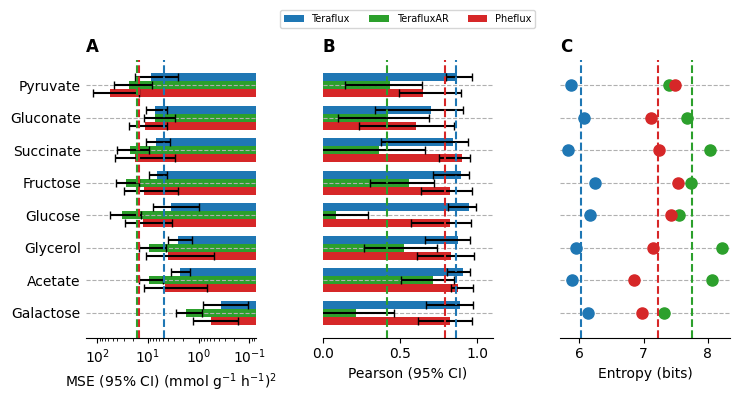

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


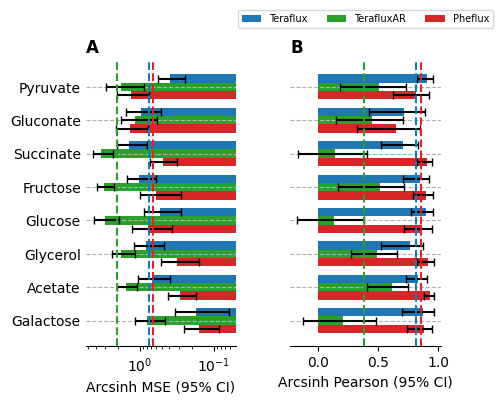

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


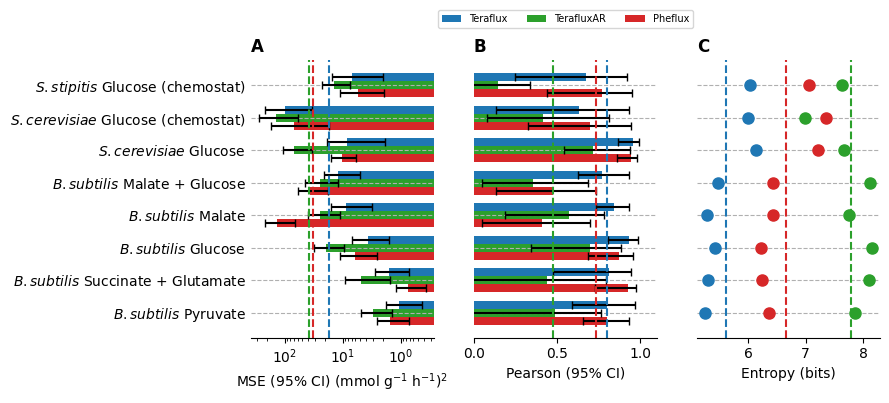

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


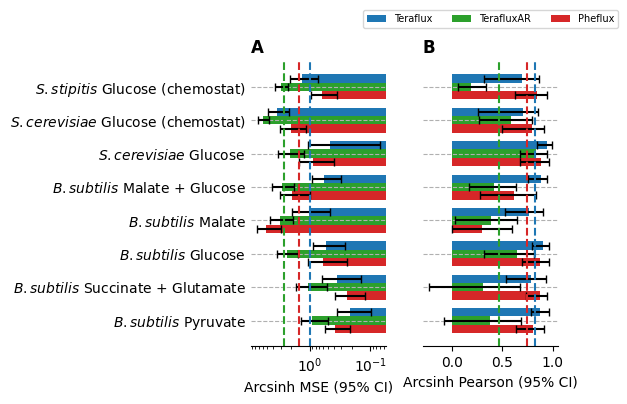

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- 0. SETUP NAMES ---
moNames = {
    "Ecoli": '$\it{E. coli}$', 
    "Bsubtilis": "$\it{B. subtilis}$", 
    "Scerevisiae": "$\it{S. cerevisiae}$", 
    "Sstipitis": "$\it{S. stipitis}$"
}

conditionNames = {}
conditionNames["Ecoli"] = {
    "ac":"Acetate", "fru":"Fructose", "gal":"Galactose", "glcn":"Gluconate",
    "glc":"Glucose", "glyc":"Glycerol", "pyr":"Pyruvate", "succ":"Succinate"
}
#conditionNames["Bsubtilis"] = {
#    "glc":"Glucose", "fru":"Fructose", "glcn":"Gluconate", "glyc":"Glycerol",
#    "mal":"Malate", "pyr":"Pyruvate", "mal_glc":"Malate + Glucose", "succ_glu":"Succinate + Glutamate"
#}
conditionNames["Bsubtilis"] = {
    "glc":"Glucose",
    "mal":"Malate", "pyr":"Pyruvate", "mal_glc":"Malate + Glucose", "succ_glu":"Succinate + Glutamate"
}
conditionNames["Scerevisiae"] = {
    "glc":"Glucose", "glc_chem":"Glucose (chemostat)"
}
#conditionNames["Sstipitis"] = {
#    "glc":"Glucose", "glc_chem":"Glucose (chemostat)"
#}
conditionNames["Sstipitis"] = {
     "glc_chem":"Glucose (chemostat)"
}

figNames = ["Ecoli", "Others"]

groupName = {"raw":{"Ecoli":"fig5", "Others":"figS1"}, 
             "arcsih":{"Ecoli":"figS6", "Others":"figS7"}}

# --- 1. MAIN LOOP (SPLIT ECOLI / OTHERS) ---
for i in range(2):
    # Filter Data
    if i == 0:
        plot_df = df[df['Data_source'] == 'Ecoli'].copy()
        title_suffix = '$\it{E. coli}$'
    else:
        plot_df = df[df['Data_source'] != 'Ecoli'].copy()
        title_suffix = "Other Species"
      
    if plot_df.empty:
        continue

    # --- APPLY PRETTY NAMES ---
    pretty_labels = []
    for _, row in plot_df.iterrows():
        mo_key = row['Data_source']
        cond_key = row['Condition']
        mo_pretty = moNames.get(mo_key, mo_key)
        cond_pretty = conditionNames.get(mo_key, {}).get(cond_key, cond_key)
        if mo_key=="Ecoli":
            pretty_labels.append(f"{cond_pretty}")
        else:
            pretty_labels.append(f"{mo_pretty} {cond_pretty}")
    
    plot_df['Label'] = pretty_labels

    # Sort (Low MSE at top)
    plot_df = plot_df.sort_values(by=['Data_source', 'Teraflux_MSE'], ascending=True)
    
    y_pos = np.arange(len(plot_df))
    height = 0.25 # Reduced height to fit 3 bars
    # Adjust figure height based on number of rows
    fig_height = len(plot_df) * 0.75 if len(plot_df) > 5 else 4
    
    # --- 2. CALCULATE ERROR BARS ---
    # Correlation
    phe_corr_err = [plot_df['Pheflux_Pearson'] - plot_df['Pheflux_Pearson_Low'], plot_df['Pheflux_Pearson_High'] - plot_df['Pheflux_Pearson']]
    tera_corr_err = [plot_df['Teraflux_Pearson'] - plot_df['Teraflux_Pearson_Low'], plot_df['Teraflux_Pearson_High'] - plot_df['Teraflux_Pearson']]
    teraAR_corr_err = [plot_df['TerafluxAR_Pearson'] - plot_df['TerafluxAR_Pearson_Low'], plot_df['TerafluxAR_Pearson_High'] - plot_df['TerafluxAR_Pearson']]
    
    # Arcsinh Correlation
    phe_arc_err = [plot_df['Pheflux_Arcsinh_Pearson'] - plot_df['Pheflux_Arcsinh_Low'], plot_df['Pheflux_Arcsinh_High'] - plot_df['Pheflux_Arcsinh_Pearson']]
    tera_arc_err = [plot_df['Teraflux_Arcsinh_Pearson'] - plot_df['Teraflux_Arcsinh_Low'], plot_df['Teraflux_Arcsinh_High'] - plot_df['Teraflux_Arcsinh_Pearson']]
    teraAR_arc_err = [plot_df['TerafluxAR_Arcsinh_Pearson'] - plot_df['TerafluxAR_Arcsinh_Low'], plot_df['TerafluxAR_Arcsinh_High'] - plot_df['TerafluxAR_Arcsinh_Pearson']]
    
    # MSE
    phe_mse_err = [plot_df['Pheflux_MSE'] - plot_df['Pheflux_MSE_Low'], plot_df['Pheflux_MSE_High'] - plot_df['Pheflux_MSE']]
    tera_mse_err = [plot_df['Teraflux_MSE'] - plot_df['Teraflux_MSE_Low'], plot_df['Teraflux_MSE_High'] - plot_df['Teraflux_MSE']]
    teraAR_mse_err = [plot_df['TerafluxAR_MSE'] - plot_df['TerafluxAR_MSE_Low'], plot_df['TerafluxAR_MSE_High'] - plot_df['TerafluxAR_MSE']]

    # Arcsinh MSE
    phe_arc_mse_err = [plot_df['Pheflux_Arcsinh_MSE'] - plot_df['Pheflux_Arcsinh_MSE_Low'], plot_df['Pheflux_Arcsinh_MSE_High'] - plot_df['Pheflux_Arcsinh_MSE']]
    tera_arc_mse_err = [plot_df['Teraflux_Arcsinh_MSE'] - plot_df['Teraflux_Arcsinh_MSE_Low'], plot_df['Teraflux_Arcsinh_MSE_High'] - plot_df['Teraflux_Arcsinh_MSE']]
    teraAR_arc_mse_err = [plot_df['TerafluxAR_Arcsinh_MSE'] - plot_df['TerafluxAR_Arcsinh_MSE_Low'], plot_df['TerafluxAR_Arcsinh_MSE_High'] - plot_df['TerafluxAR_Arcsinh_MSE']]
    
    # Averages
    avg_phe_corr = plot_df['Pheflux_Pearson'].mean()
    avg_tera_corr = plot_df['Teraflux_Pearson'].mean()
    avg_teraAR_corr = plot_df['TerafluxAR_Pearson'].mean()

    avg_phe_mse = plot_df['Pheflux_MSE'].mean()
    avg_tera_mse = plot_df['Teraflux_MSE'].mean()
    avg_teraAR_mse = plot_df['TerafluxAR_MSE'].mean()

    avg_phe_ent = plot_df['Pheflux_Entropy'].mean()
    avg_tera_ent = plot_df['Teraflux_Entropy'].mean()
    avg_teraAR_ent = plot_df['TerafluxAR_Entropy'].mean()

    avg_phe_arc = plot_df['Pheflux_Arcsinh_Pearson'].mean()
    avg_tera_arc = plot_df['Teraflux_Arcsinh_Pearson'].mean()
    avg_teraAR_arc = plot_df['TerafluxAR_Arcsinh_Pearson'].mean()

    avg_phe_arc_mse = plot_df['Pheflux_Arcsinh_MSE'].mean()
    avg_tera_arc_mse = plot_df['Teraflux_Arcsinh_MSE'].mean()
    avg_teraAR_arc_mse = plot_df['TerafluxAR_Arcsinh_MSE'].mean()

    # --- 3. FIGURE 1: 3-PANEL (MSE, Corr, Entropy) ---
    if i==0: #E. coli plot
        fig, (ax_mse, ax_corr, ax_ent) = plt.subplots(ncols=3, sharey=True, figsize=(15*0.5, fig_height*0.7))
    else:
        fig, (ax_mse, ax_corr, ax_ent) = plt.subplots(ncols=3, sharey=True, figsize=(15*0.6, fig_height*0.7))

    
    # Shared Styling (No Boxes)
    for ax in [ax_mse, ax_corr, ax_ent]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.grid(axis='y', linestyle='--',  zorder=0)
        ax.tick_params(axis='y', length=0)

    # --- LEFT PANEL: MSE (BARS) ---
    # Teraflux (Top)
    ax_mse.barh(y_pos + height, plot_df['Teraflux_MSE'], height=height, xerr=tera_mse_err, capsize=3, color='#1F77B4', label='Teraflux')
    # TerafluxAR (Middle)
    ax_mse.barh(y_pos, plot_df['TerafluxAR_MSE'], height=height, xerr=teraAR_mse_err, capsize=3, color='#2CA02C', label='TerafluxAR') # Green
    # Pheflux (Bottom)
    ax_mse.barh(y_pos - height, plot_df['Pheflux_MSE'], height=height, xerr=phe_mse_err, capsize=3, color='#D62728', label='Pheflux')
    
    ax_mse.axvline(avg_phe_mse, color='#D62728', linestyle='--', linewidth=1.5)
    ax_mse.axvline(avg_tera_mse, color='#1F77B4', linestyle='--', linewidth=1.5)
    ax_mse.axvline(avg_teraAR_mse, color='#2CA02C', linestyle='--', linewidth=1.5)
    
    ax_mse.set_xlabel('MSE (95% CI) (mmol g$^{-1}$ h$^{-1}$)$^{2}$')
    ax_mse.set_xscale("log") 
    ax_mse.invert_xaxis() # Lowest error on right
    
    # Labels now belong to this left-most plot
    ax_mse.set_yticks(y_pos)
    ax_mse.set_yticklabels(plot_df['Label'], fontsize=10)
    ax_mse.set_title("A",loc="left",fontweight='bold')

    # --- MIDDLE PANEL: CORRELATION (BARS) ---
    ax_corr.barh(y_pos + height, plot_df['Teraflux_Pearson'], height=height, xerr=tera_corr_err, capsize=3, color='#1F77B4',  label='Teraflux')
    ax_corr.barh(y_pos, plot_df['TerafluxAR_Pearson'], height=height, xerr=teraAR_corr_err, capsize=3, color='#2CA02C',  label='TerafluxAR')
    ax_corr.barh(y_pos - height, plot_df['Pheflux_Pearson'], height=height, xerr=phe_corr_err, capsize=3, color='#D62728',  label='Pheflux')
    
    ax_corr.axvline(avg_phe_corr, color='#D62728', linestyle='--', linewidth=1.5)
    ax_corr.axvline(avg_tera_corr, color='#1F77B4', linestyle='--', linewidth=1.5)
    ax_corr.axvline(avg_teraAR_corr, color='#2CA02C', linestyle='--', linewidth=1.5)
    
    ax_corr.set_xlabel('Pearson (95% CI)')
    ax_corr.set_xlim(0, 1.1)
    ax_corr.set_title("B",loc="left",fontweight='bold')
    ax_corr.legend(loc='center', fontsize=7, frameon=True,ncol=3,bbox_to_anchor=[0.5,1.15])    


    # --- RIGHT PANEL: ENTROPY (DOTS) ---
    ax_ent.plot(plot_df['Teraflux_Entropy'], y_pos, 'o', color='#1F77B4', markersize=8, label='Teraflux')
    ax_ent.plot(plot_df['TerafluxAR_Entropy'], y_pos, 'o', color='#2CA02C', markersize=8, label='TerafluxAR')
    ax_ent.plot(plot_df['Pheflux_Entropy'], y_pos, 'o', color='#D62728', markersize=8, label='Pheflux')
    
    ax_ent.axvline(avg_phe_ent, color='#D62728', linestyle='--', linewidth=1.5)
    ax_ent.axvline(avg_tera_ent, color='#1F77B4', linestyle='--', linewidth=1.5)
    ax_ent.axvline(avg_teraAR_ent, color='#2CA02C', linestyle='--', linewidth=1.5)
    
    ax_ent.set_xlabel('Entropy (bits)')
    ax_ent.set_title("C",loc="left",fontweight='bold')

    plt.tight_layout()
    plt.savefig(f"{groupName['raw'][figNames[i]]}.svg", dpi=300, bbox_inches='tight')
    plt.savefig(f"{groupName['raw'][figNames[i]]}.eps", dpi=300, bbox_inches='tight')    
    plt.show()

    # --- 4. FIGURE 2: ARCSINH MULTIPANEL (MSE, Corr) ---
    if i==0: # E.coli plot
        fig2, (ax_arc_mse, ax_arc_corr) = plt.subplots(ncols=2, sharey=True, figsize=(10*0.5, fig_height*0.7))
    else:
        fig2, (ax_arc_mse, ax_arc_corr) = plt.subplots(ncols=2, sharey=True, figsize=(10*0.6, fig_height*0.7))
        
    for ax in [ax_arc_mse, ax_arc_corr]:
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.grid(axis='y', linestyle='--',  zorder=0)
        ax.tick_params(axis='y', length=0)

    # --- LEFT PANEL: ARCSINH MSE ---
    ax_arc_mse.barh(y_pos + height, plot_df['Teraflux_Arcsinh_MSE'], height=height, xerr=tera_arc_mse_err, capsize=3, color='#1F77B4', label='Teraflux')
    ax_arc_mse.barh(y_pos, plot_df['TerafluxAR_Arcsinh_MSE'], height=height, xerr=teraAR_arc_mse_err, capsize=3, color='#2CA02C', label='TerafluxAR')
    ax_arc_mse.barh(y_pos - height, plot_df['Pheflux_Arcsinh_MSE'], height=height, xerr=phe_arc_mse_err, capsize=3, color='#D62728', label='Pheflux')

    ax_arc_mse.axvline(avg_phe_arc_mse, color='#D62728', linestyle='--', linewidth=1.5)
    ax_arc_mse.axvline(avg_tera_arc_mse, color='#1F77B4', linestyle='--', linewidth=1.5)
    ax_arc_mse.axvline(avg_teraAR_arc_mse, color='#2CA02C', linestyle='--', linewidth=1.5)

    ax_arc_mse.set_xlabel('Arcsinh MSE (95% CI)')
    ax_arc_mse.set_xscale("log") 
    ax_arc_mse.invert_xaxis() # Lowest error on right
    ax_arc_mse.set_yticks(y_pos)
    ax_arc_mse.set_yticklabels(plot_df['Label'], fontsize=10)
    ax_arc_mse.set_title("A", loc="left", fontweight='bold')

    # --- RIGHT PANEL: ARCSINH CORRELATION ---
    ax_arc_corr.barh(y_pos + height, plot_df['Teraflux_Arcsinh_Pearson'], height=height, xerr=tera_arc_err, capsize=3, color='#1F77B4',  label='Teraflux')
    ax_arc_corr.barh(y_pos, plot_df['TerafluxAR_Arcsinh_Pearson'], height=height, xerr=teraAR_arc_err, capsize=3, color='#2CA02C',  label='TerafluxAR')
    ax_arc_corr.barh(y_pos - height, plot_df['Pheflux_Arcsinh_Pearson'], height=height, xerr=phe_arc_err, capsize=3, color='#D62728',  label='Pheflux')

    
    ax_arc_corr.axvline(avg_phe_arc, color='#D62728', linestyle='--', linewidth=1.5)
    ax_arc_corr.axvline(avg_tera_arc, color='#1F77B4', linestyle='--', linewidth=1.5) 
    ax_arc_corr.axvline(avg_teraAR_arc, color='#2CA02C', linestyle='--', linewidth=1.5) 

    ax_arc_corr.set_xlabel('Arcsinh Pearson (95% CI)')
    ax_arc_corr.set_title("B", loc="left", fontweight='bold')
    ax_arc_corr.legend(loc='center', fontsize=7, frameon=True,ncol=3,bbox_to_anchor=[0.5,1.15])

    plt.tight_layout()
    plt.savefig(f"{groupName['arcsih'][figNames[i]]}.svg", dpi=300, bbox_inches='tight')
    plt.savefig(f"{groupName['arcsih'][figNames[i]]}.eps", dpi=300, bbox_inches='tight')    
    plt.show()

In [24]:
import pandas as pd
import numpy as np

# Assuming 'df' is available from the previous steps. 
# If running standalone, you would need to load the dataframe first.
# For this script, I will assume 'df' is populated as per "Metrics_Computation_Update.py".

# Define the metrics we want to average
metrics_base = ['MSE', 'Pearson', 'Entropy', 'Arcsinh_MSE', 'Arcsinh_Pearson']
methods = ['Pheflux', 'Teraflux', 'TerafluxAR']

# Construct the full column names
columns_to_avg = []
for method in methods:
    for metric in metrics_base:
        columns_to_avg.append(f"{method}_{metric}")

# --- HELPER TO CALCULATE GROUP AVERAGES ---
def calculate_group_averages(data_df, group_name):
    # Select only the numeric columns relevant to our metrics
    subset = data_df[columns_to_avg]
    # Calculate mean
    means = subset.mean()
    # Create a DataFrame for this group
    means_df = means.to_frame(name=group_name).T
    return means_df

# --- 1. ALL CONDITIONS ---
avg_all = calculate_group_averages(df, "All Conditions")

# --- 2. E. COLI SAMPLES ---
df_ecoli = df[df['Data_source'] == 'Ecoli']
avg_ecoli = calculate_group_averages(df_ecoli, "E. coli Only")

# --- 3. NON-E. COLI SAMPLES ---
df_others = df[df['Data_source'] != 'Ecoli']
avg_others = calculate_group_averages(df_others, "Non-E. coli Only")

# --- COMBINE AND DISPLAY ---
summary_table = pd.concat([avg_all, avg_ecoli, avg_others])

# Transpose for easier reading (Metrics as rows, Groups as columns)
summary_table_T = summary_table.T

print("--- AVERAGE METRICS SUMMARY ---")
print(summary_table_T)

# Optional: Save to CSV
# summary_table_T.to_csv("Average_Metrics_Summary.csv")

--- AVERAGE METRICS SUMMARY ---
                            All Conditions  E. coli Only  Non-E. coli Only
Pheflux_MSE                      23.854168     14.816444         32.891891
Pheflux_Pearson                   0.764126      0.791125          0.737126
Pheflux_Entropy                   6.945417      7.224887          6.665946
Pheflux_Arcsinh_MSE               1.080826      0.672273          1.489379
Pheflux_Arcsinh_Pearson           0.803365      0.856499          0.750230
Teraflux_MSE                     11.102623      4.801585         17.403660
Teraflux_Pearson                  0.833750      0.864687          0.802814
Teraflux_Entropy                  5.817877      6.018708          5.617047
Teraflux_Arcsinh_MSE              0.877986      0.756522          0.999450
Teraflux_Arcsinh_Pearson          0.819171      0.817803          0.820539
TerafluxAR_MSE                   27.117375     16.703033         37.531718
TerafluxAR_Pearson                0.445562      0.413856          0.

/usr/local/lib/python3.10/dist-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


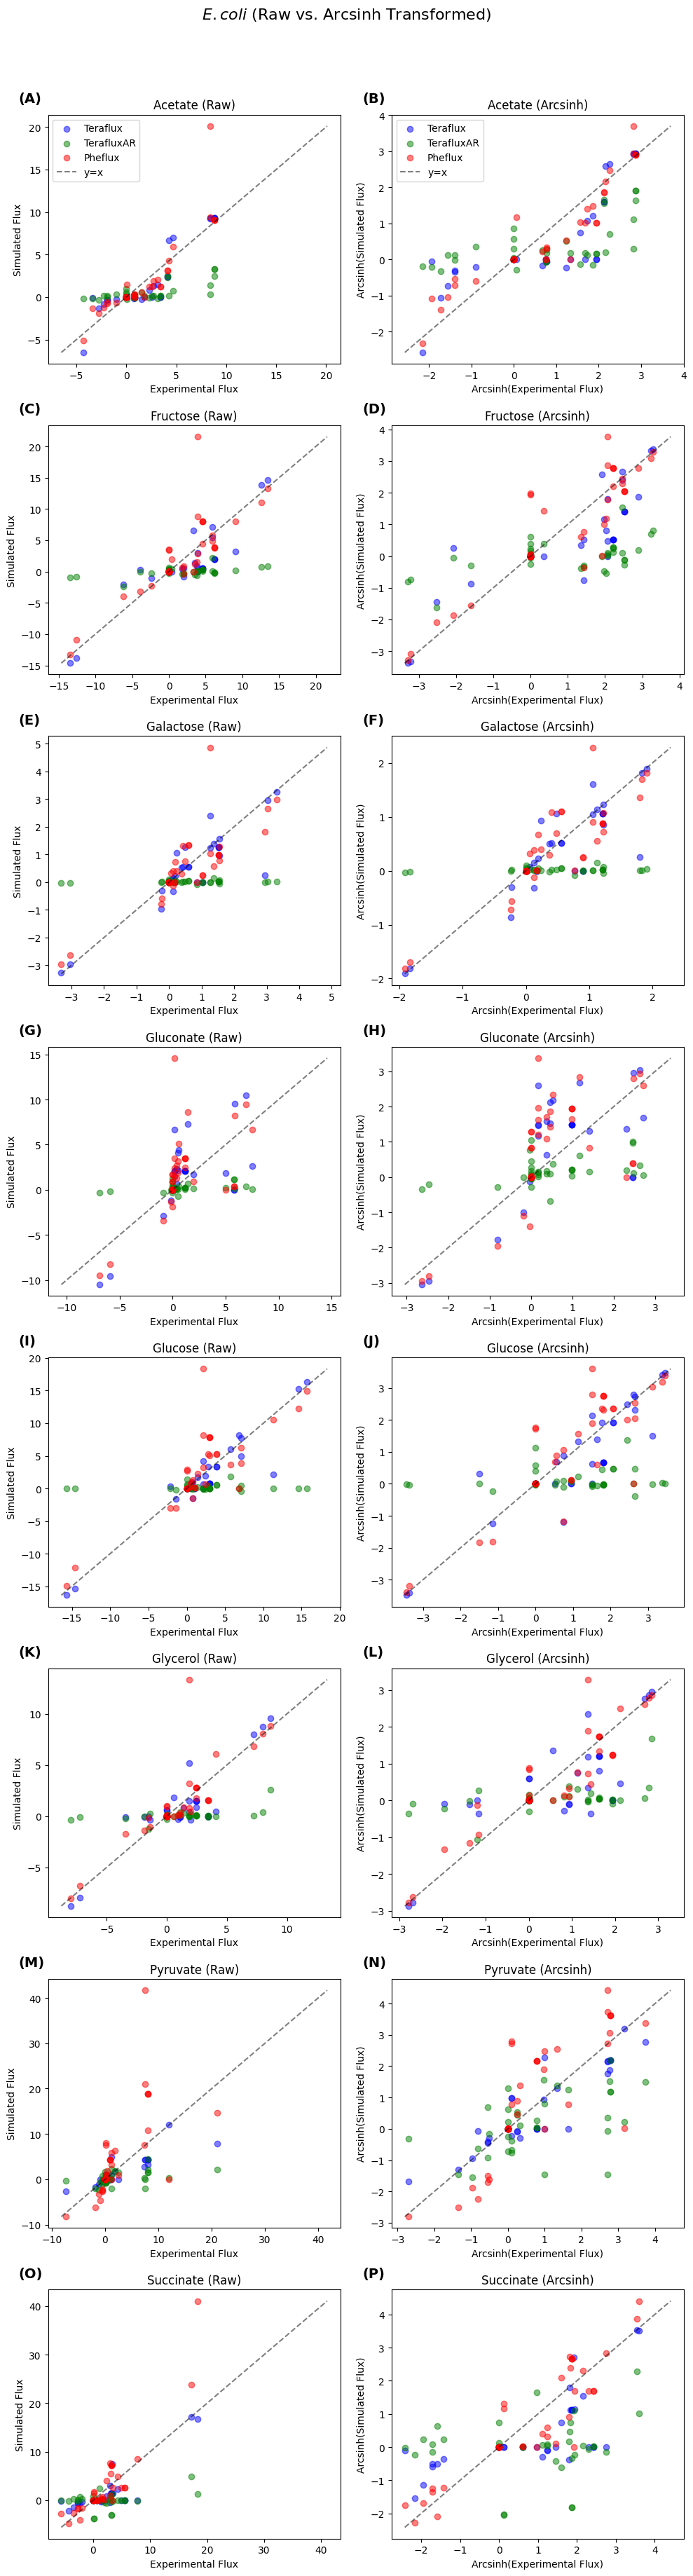

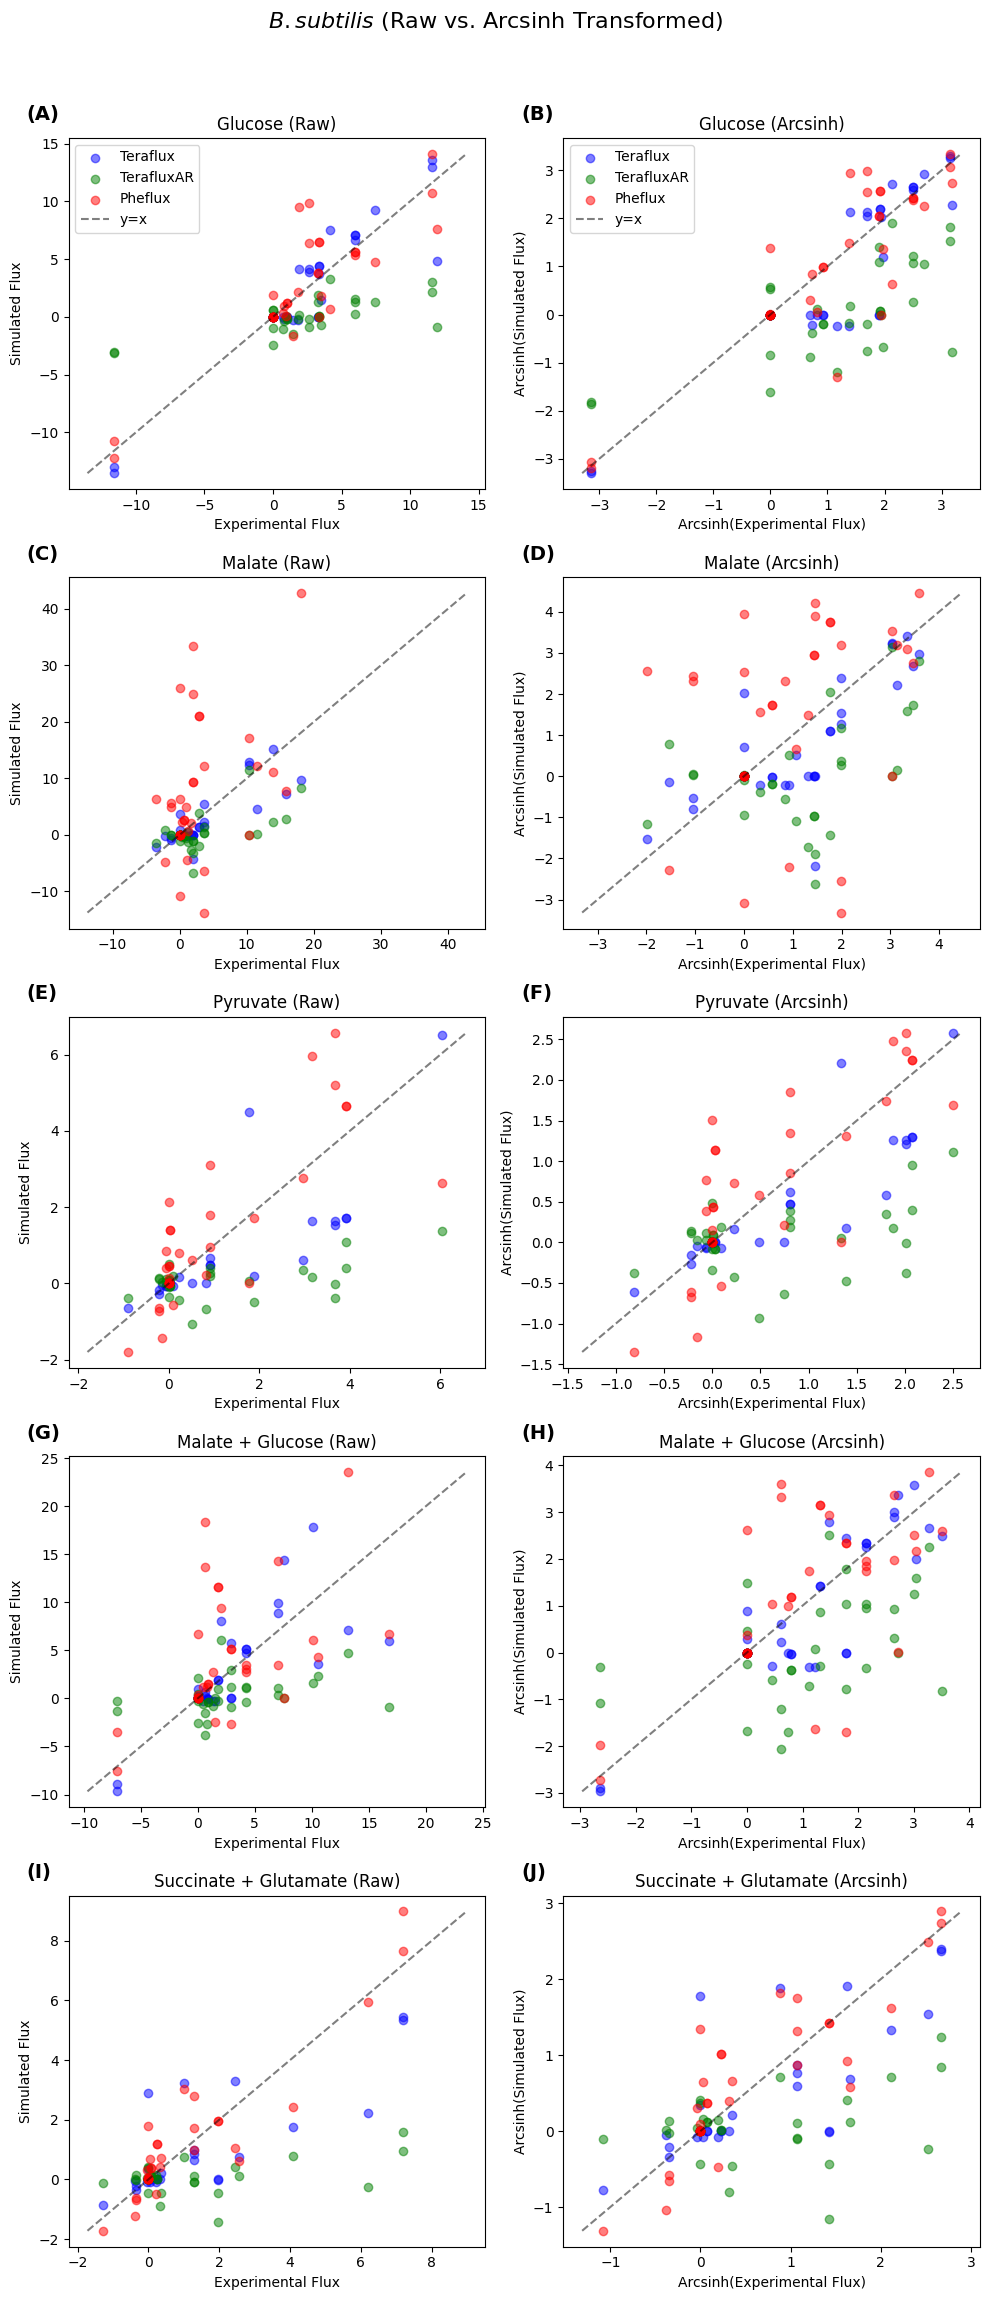

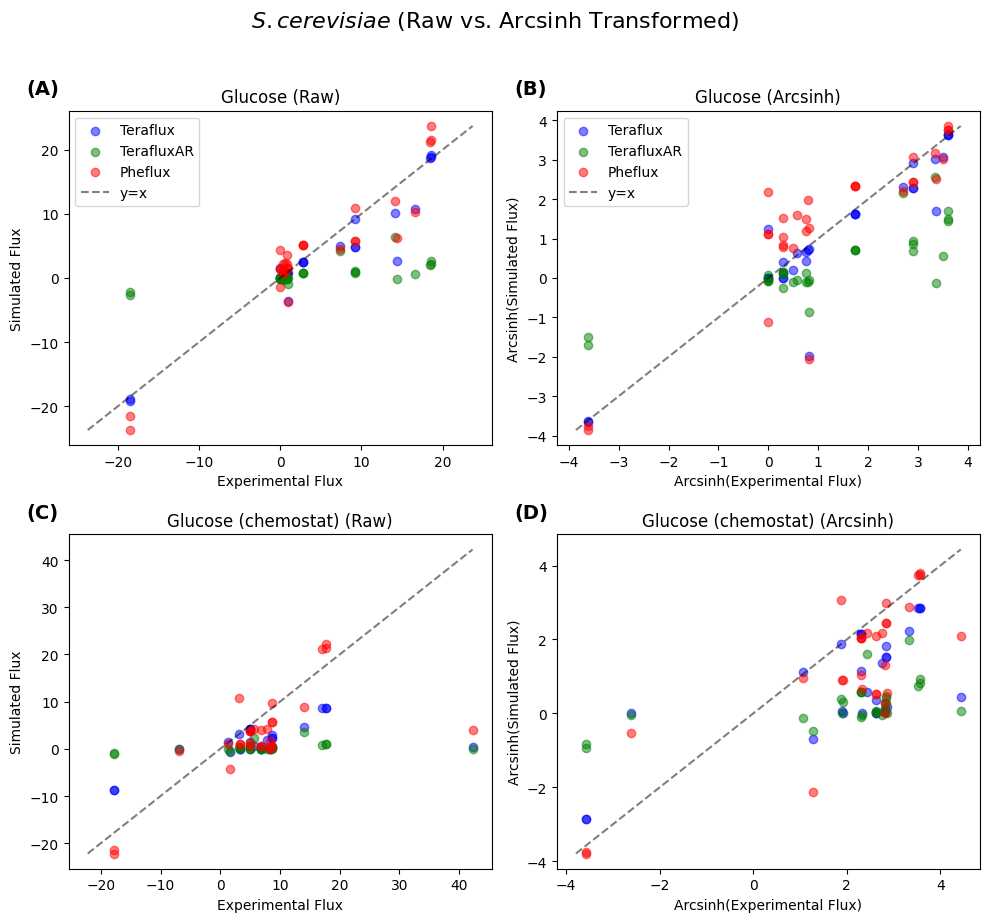

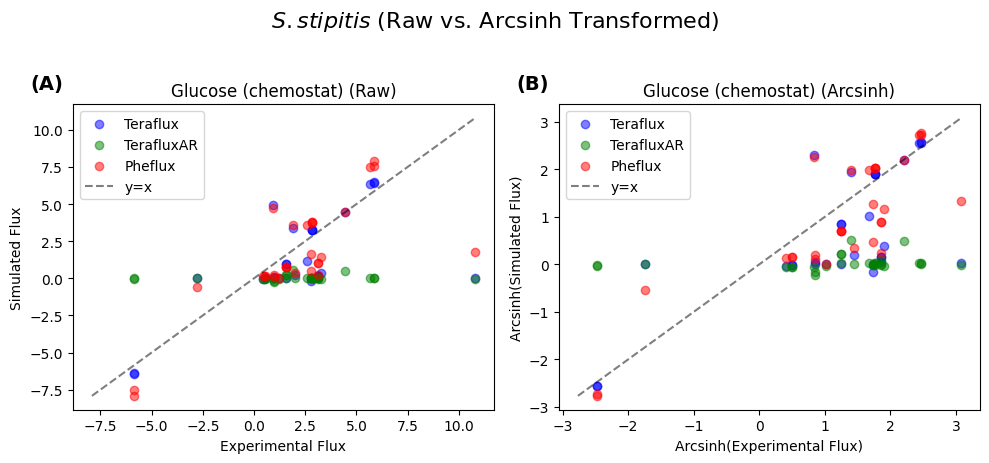

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import glob
import string

def arcsinh_transform(x):
    return np.arcsinh(x)

# Ordered list of microorganisms
mos_list = ["Ecoli", "Bsubtilis", "Scerevisiae", "Sstipitis"]

# Reaction codes for parsing files
reaction_codes = {
    "Ecoli": {"ac":["EX_ac_e"], "fru":["EX_fru_e"], "gal":["EX_gal_e"], "glcn":["EX_glcn_e"], "glc":["EX_glc__D_e"], "glyc":["EX_glyc_e"], "pyr":["EX_pyr_e"], "succ":["EX_succ_e"]},
    "Bsubtilis": {"glc":["EX_glc__D_e"], "mal":["EX_mal__L_e"], "pyr":["EX_pyr_e"], "mal_glc":["EX_mal__L_e","EX_glc__D_e"], "succ_glu":["EX_succ_e","EX_glu__L_e"]},
    "Scerevisiae": {"glc":["EX_glc__D_e"], "glc_chem":["EX_glc__D_e"]},
    "Sstipitis": {"glc_chem":["SS1232"]}
}

# Formatting dictionaries (using raw strings r'' for LaTeX compatibility in matplotlib)
moNames = {
    "Ecoli": r'$\it{E. coli}$', 
    "Bsubtilis": r"$\it{B. subtilis}$", 
    "Scerevisiae": r"$\it{S. cerevisiae}$", 
    "Sstipitis": r"$\it{S. stipitis}$"
}

conditionNames = {
    "Ecoli": {
        "ac":"Acetate", "fru":"Fructose", "gal":"Galactose", "glcn":"Gluconate",
        "glc":"Glucose", "glyc":"Glycerol", "pyr":"Pyruvate", "succ":"Succinate"
    },
    "Bsubtilis": {
        "glc":"Glucose", "mal":"Malate", "pyr":"Pyruvate", 
        "mal_glc":"Malate + Glucose", "succ_glu":"Succinate + Glutamate"
    },
    "Scerevisiae": {
        "glc":"Glucose", "glc_chem":"Glucose (chemostat)"
    },
    "Sstipitis": {
         "glc_chem":"Glucose (chemostat)"
    }
}

path = "/home/marcelo/jupyter/teraflux/fig5"
panel_letters = string.ascii_uppercase

for mo in mos_list:
    conditions = list(reaction_codes[mo].keys())
    n_cond = len(conditions)
    
    # Create a figure for the current organism (Rows = conditions, Cols = 2 for Raw/Arcsinh)
    fig, axes = plt.subplots(nrows=n_cond, ncols=2, figsize=(10, 4.5 * n_cond))
    
    # Ensure axes is 2D even if there's only 1 condition
    if n_cond == 1:
        axes = np.array([axes])
        
    panel_idx = 0
    fig.suptitle(f"{moNames[mo]} (Raw vs. Arcsinh Transformed)", fontsize=16, y=1.02)
    
    for i, condition in enumerate(conditions):
        folder1 = f"{path}/{mo}/experimental"
        folder2 = f"{path}/{mo}/results/pheflux"
        folder3 = f"{path}/{mo}/results/teraflux"
        folder4 = f"{path}/{mo}/results/teraflux_allReversible"
        
        # Load Data
        try:
            exp = pd.read_csv(f"{folder1}/{mo}_Fluxfile_{condition}.csv", sep="\t", lineterminator="\n").set_index("Reaction_ID")
            pheflux = pd.read_csv(glob.glob(f"{folder2}/{mo}_{condition}*.fluxes.csv")[0], sep="\t", lineterminator="\n", names=['Reaction_ID', "Flux"]).set_index("Reaction_ID") 
            teraflux = pd.read_csv(f"{folder3}/{mo}_{condition}.fluxes.csv", sep=",", lineterminator="\n", names=['Reaction_ID', "Flux"]).set_index("Reaction_ID") 
            terafluxAR = pd.read_csv(f"{folder4}/{mo}_{condition}.fluxes.csv", sep=",", lineterminator="\n", names=['Reaction_ID', "Flux"]).set_index("Reaction_ID")
        except (IndexError, FileNotFoundError):
            print(f"Skipping {mo} {condition} - Missing files")
            continue

        fluxes = pd.DataFrame(columns=["Experimental", "Pheflux", "Teraflux", "TerafluxAR"])
        
        denom_rxn = "R_" + reaction_codes[mo][condition][0]
        denom = pheflux.loc[denom_rxn].Flux if denom_rxn in pheflux.index and pheflux.loc[denom_rxn].Flux != 0 else 1e-9
        alpha = exp.loc[reaction_codes[mo][condition][0]].Flux / denom
        
        for reaction in exp.index:
            if ("Growth_rate" in reaction) or (reaction in reaction_codes[mo][condition]): 
                continue
            try:
                phe_val = pheflux.loc["R_" + reaction].Flux * alpha
                tera_val = teraflux.loc["R_" + reaction].Flux
                teraAR_val = terafluxAR.loc["R_" + reaction].Flux 
                fluxes.loc[reaction] = [exp.loc[reaction].Flux, phe_val, tera_val, teraAR_val]
            except KeyError:
                continue
                
        fluxes = fluxes.astype(float)
        
        cond_display_name = conditionNames[mo][condition]
        
        # ---------------------------------------------------------
        # Plot 1: Raw Data (Left Column)
        # ---------------------------------------------------------
        ax_raw = axes[i, 0]
        ax_raw.scatter(fluxes["Experimental"], fluxes["Teraflux"], color='blue', alpha=0.5, label='Teraflux')
        ax_raw.scatter(fluxes["Experimental"], fluxes["TerafluxAR"], color='green', alpha=0.5, label='TerafluxAR')
        ax_raw.scatter(fluxes["Experimental"], fluxes["Pheflux"], color='red', alpha=0.5, label='Pheflux')
        
        # 1:1 Reference line
        min_val = min(fluxes["Experimental"].min(), fluxes[["Pheflux", "Teraflux", "TerafluxAR"]].min().min())
        max_val = max(fluxes["Experimental"].max(), fluxes[["Pheflux", "Teraflux", "TerafluxAR"]].max().max())
        ax_raw.plot([min_val, max_val], [min_val, max_val], 'k--', alpha=0.5, label='y=x')
        
        ax_raw.set_title(f"{cond_display_name} (Raw)")
        ax_raw.set_xlabel("Experimental Flux")
        ax_raw.set_ylabel("Simulated Flux")
        ax_raw.text(-0.1, 1.05, f"({panel_letters[panel_idx]})", transform=ax_raw.transAxes, size=14, weight='bold')
        panel_idx += 1
        
        # ---------------------------------------------------------
        # Plot 2: Arcsinh Transformed Data (Right Column)
        # ---------------------------------------------------------
        ax_arc = axes[i, 1]
        exp_arc = arcsinh_transform(fluxes["Experimental"])
        phe_arc = arcsinh_transform(fluxes["Pheflux"])
        tera_arc = arcsinh_transform(fluxes["Teraflux"])
        teraar_arc = arcsinh_transform(fluxes["TerafluxAR"])
        
        ax_arc.scatter(exp_arc, tera_arc, color='blue', alpha=0.5, label='Teraflux')
        ax_arc.scatter(exp_arc, teraar_arc, color='green', alpha=0.5, label='TerafluxAR')
        ax_arc.scatter(exp_arc, phe_arc, color='red', alpha=0.5, label='Pheflux')
        
        # 1:1 Reference line
        min_arc = min(exp_arc.min(), pd.concat([phe_arc, tera_arc, teraar_arc]).min())
        max_arc = max(exp_arc.max(), pd.concat([phe_arc, tera_arc, teraar_arc]).max())
        ax_arc.plot([min_arc, max_arc], [min_arc, max_arc], 'k--', alpha=0.5, label='y=x')
        
        ax_arc.set_title(f"{cond_display_name} (Arcsinh)")
        ax_arc.set_xlabel("Arcsinh(Experimental Flux)")
        ax_arc.set_ylabel("Arcsinh(Simulated Flux)")
        ax_arc.text(-0.1, 1.05, f"({panel_letters[panel_idx]})", transform=ax_arc.transAxes, size=14, weight='bold')
        panel_idx += 1
        
        if i == 0:
            ax_raw.legend(loc='upper left')
            ax_arc.legend(loc='upper left')
            
    plt.tight_layout()
    plt.show()